## Analysis of PTNs


**Findings:**
- MPS distribution correctly learns a gaussian
- Gradients vanish as horizon increased
- Images dist lower rank than language dist

**Ideas:**
- (Vanishing gradient) when updating the kth core replace all cores ata distance of 5 away with identity mats
- (Vanishing gradient) orthogonal parameterization of 50% of the cores

### Visualize data

In [52]:
import torch

class SyntheticDataset(torch.utils.data.Dataset):
    def __init__(self, n_samples: int, d_output: int = 256, horizon: int = 2):
        self.n_samples = n_samples
        self.d_output = d_output
        self.horizon = horizon

        # Use smaller sigma so values rarely exceed [0, 1]
        sigma = 0.15  # tune this (0.1–0.2 usually works well)
        samples = torch.randn(n_samples, horizon) * sigma + 0.5

        # Discretize to [0, d_output - 1]
        samples = (samples * d_output).clamp(0, d_output - 1).round().to(torch.long)

        self.samples = samples

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx: int):
        return self.samples[idx]


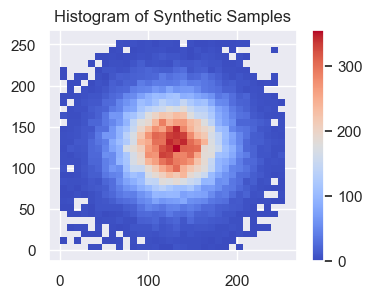

Sample shape: (50000, 8)


In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_samples(samples, title="Histogram of Synthetic Samples", x_idx=0, y_idx=1):
    plt.figure(figsize=(4, 3))
    sns.histplot(x=samples[:,x_idx], y=samples[:,y_idx], bins=32, cbar=True, cmap="coolwarm")
    plt.title(title)
    plt.show()


# Hyperparameters
d_model = 1
d_output = 256
horizon = 8
rank = 1

dataset = SyntheticDataset(50_000, d_output=d_output, horizon=horizon).samples.numpy()
plot_samples(dataset)
print("Sample shape:", dataset.shape)



In [54]:
from ptn.dists import dists
from ptn.dists._abc import AbstractDisributionHeadConfig
model = dists['mps_sigma_lsf'](
    AbstractDisributionHeadConfig(
        d_model=d_model,
        d_output=d_output,
        horizon=horizon,
        rank=rank,
    )
)
generated_rand = model.generate(torch.ones(50_000, 1))

In [55]:
# Train model

# Hyperparameters
n_epochs = 10
batch_size = 128
lr = 1e-3

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
grads = []
losses = []
for epoch in range(n_epochs):
    train_losses = []
    for i, batch in enumerate(dataloader):
        output = model(torch.ones(batch.size(0), 1), batch)
        optimizer.zero_grad()
        output.loss.backward()
        optimizer.step()
        grads.append(torch.nn.utils.clip_grad_norm(model.parameters(), 1.0))
        train_losses.append(output.loss.item())
    loss_avg = sum(train_losses)/len(train_losses)
    losses.append(loss_avg)
    print(f"[Epoch {epoch+1}/{n_epochs}] Loss: {loss_avg:.2f}")



/var/folders/r_/d81gvkws1n5fg2_7mb57cwzh0000gn/T/ipykernel_94078/44930301.py:19: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  grads.append(torch.nn.utils.clip_grad_norm(model.parameters(), 1.0))


[Epoch 1/10] Loss: 5.65
[Epoch 2/10] Loss: 5.47
[Epoch 3/10] Loss: 5.32
[Epoch 4/10] Loss: 5.22
[Epoch 5/10] Loss: 5.16
[Epoch 6/10] Loss: 5.12
[Epoch 7/10] Loss: 5.10
[Epoch 8/10] Loss: 5.09
[Epoch 9/10] Loss: 5.08
[Epoch 10/10] Loss: 5.07


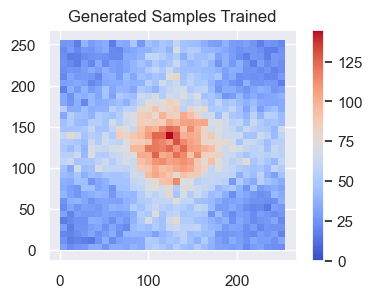

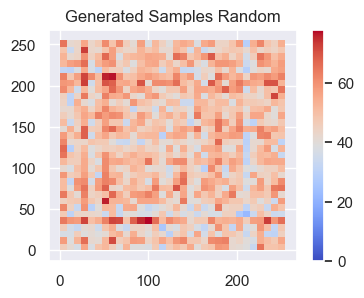

In [56]:
generated_trained = model.generate(torch.ones(50000, 1))

# Plot generated_trained and generated_rand
plot_samples(generated_trained.numpy(), "Generated Samples Trained")
plot_samples(generated_rand.numpy(), "Generated Samples Random")


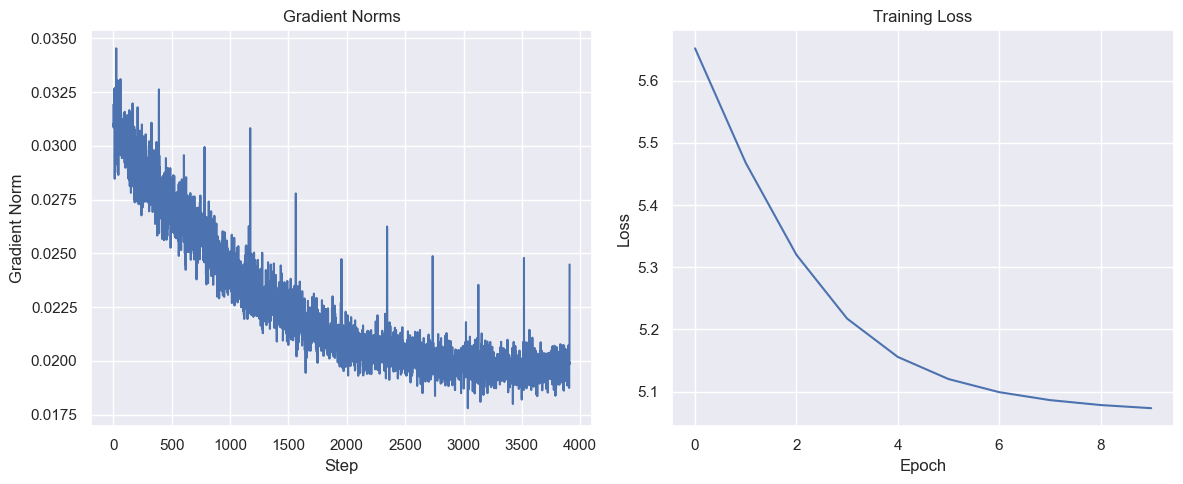

In [57]:
# With H=32
# Plot grads and losses side by side using matplotlib and seaborn
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot grads
sns.lineplot(x=range(len(grads)), y=torch.tensor(grads).tolist(), ax=axes[0])
axes[0].set_title("Gradient Norms")
axes[0].set_xlabel("Step")
axes[0].set_ylabel("Gradient Norm")

# Plot losses
sns.lineplot(x=range(len(losses)), y=losses, ax=axes[1])
axes[1].set_title("Training Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")

plt.tight_layout()
plt.show()


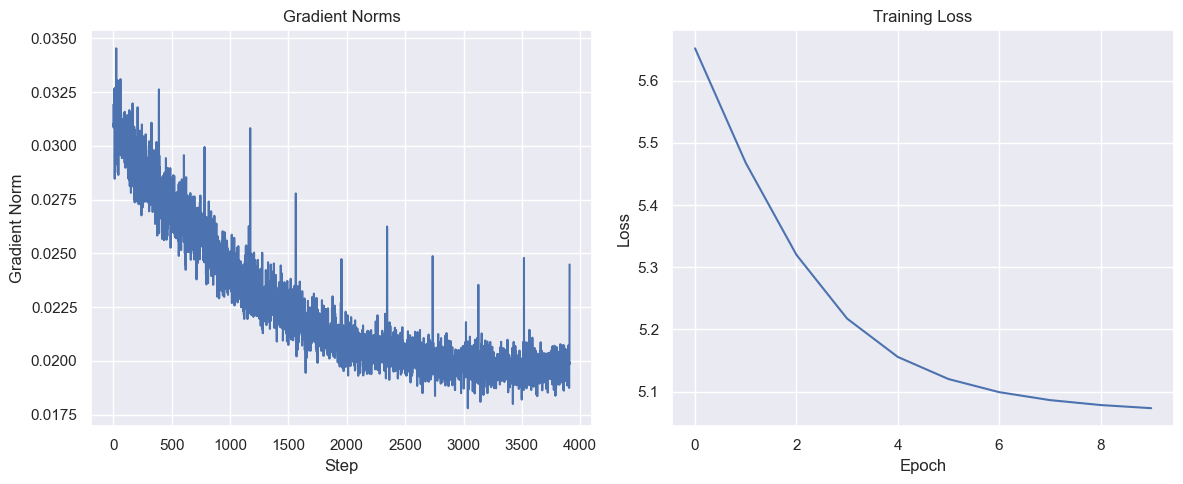

In [58]:
# With H=2
# Plot grads and losses side by side using matplotlib and seaborn
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot grads
sns.lineplot(x=range(len(grads)), y=torch.tensor(grads).tolist(), ax=axes[0])
axes[0].set_title("Gradient Norms")
axes[0].set_xlabel("Step")
axes[0].set_ylabel("Gradient Norm")

# Plot losses
sns.lineplot(x=range(len(losses)), y=losses, ax=axes[1])
axes[1].set_title("Training Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")

plt.tight_layout()
plt.show()


### Gradient vanishing problem in MPS

In [59]:
# Compare different horizons

from ptn.dists import dists
from ptn.dists._abc import AbstractDisributionHeadConfig

# Hyperparameters
d_model = 1
d_output = 256
rank = 1
n_epochs = 10
n_samples = 5000
batch_size = 128
lr = 1e-3
horizons = [8, 32, 128]

records_grads = []  
records_loss = []

def flatten(lst: list[torch.Tensor]) -> torch.Tensor:
    # Filter out None values
    lst = [l for l in lst if l is not None]
    return torch.cat([l.detach().flatten() for l in lst])

for horizon in horizons:
    dataset = SyntheticDataset(n_samples, d_output=d_output, horizon=horizon).samples.numpy()
    model = dists['mps_sigma_lsf'](
        AbstractDisributionHeadConfig(
            d_model=d_model,
            d_output=d_output,
            horizon=horizon,
            rank=rank,
        )
    )

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    for epoch in range(n_epochs):
        train_losses = []
        for i, batch in enumerate(dataloader):
            n = epoch * len(dataloader) + i  # iteration number
            output = model(torch.ones(batch.size(0), 1), batch)
            optimizer.zero_grad()
            output.loss.backward()
            records_grads.append({
                "horizon": horizon, 
                "iter": n, 
                "grad_norm": flatten([l.grad for l in model.parameters()]).norm().item(),
                "param_norm": flatten([l for l in model.parameters()]).norm().item()
            })
            optimizer.step()
            train_losses.append(output.loss.item())
        loss_avg = sum(train_losses)/len(train_losses)
        records_loss.append({"horizon": horizon, "iter": n, "loss": loss_avg})
        print(f"[Epoch {epoch+1}/{n_epochs}] Loss: {loss_avg:.2f}")



[Epoch 1/10] Loss: 5.73
[Epoch 2/10] Loss: 5.71
[Epoch 3/10] Loss: 5.69
[Epoch 4/10] Loss: 5.67
[Epoch 5/10] Loss: 5.65
[Epoch 6/10] Loss: 5.63
[Epoch 7/10] Loss: 5.61
[Epoch 8/10] Loss: 5.59
[Epoch 9/10] Loss: 5.57
[Epoch 10/10] Loss: 5.55
[Epoch 1/10] Loss: 5.73
[Epoch 2/10] Loss: 5.71
[Epoch 3/10] Loss: 5.69
[Epoch 4/10] Loss: 5.67
[Epoch 5/10] Loss: 5.64
[Epoch 6/10] Loss: 5.62
[Epoch 7/10] Loss: 5.60
[Epoch 8/10] Loss: 5.58
[Epoch 9/10] Loss: 5.56
[Epoch 10/10] Loss: 5.54
[Epoch 1/10] Loss: 5.74
[Epoch 2/10] Loss: 5.72
[Epoch 3/10] Loss: 5.70
[Epoch 4/10] Loss: 5.68
[Epoch 5/10] Loss: 5.66
[Epoch 6/10] Loss: 5.63
[Epoch 7/10] Loss: 5.61
[Epoch 8/10] Loss: 5.59
[Epoch 9/10] Loss: 5.57
[Epoch 10/10] Loss: 5.55


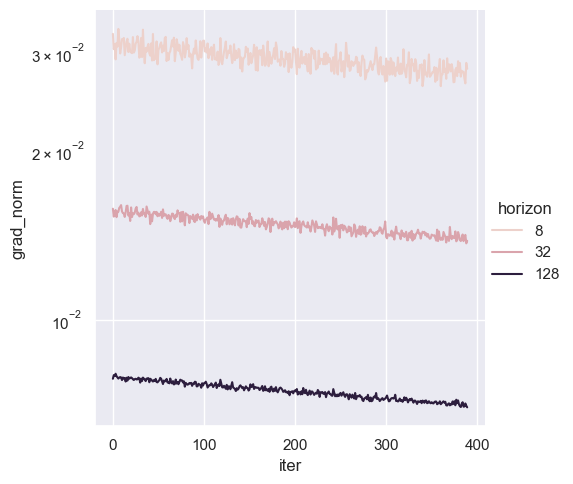

In [60]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert records_grads to a DataFrame for easy plotting
df_grads = pd.DataFrame(records_grads)
sns.set_theme(style="darkgrid")
sns.relplot(
    data=df_grads,
    x="iter",
    y="grad_norm",
    kind="line",
    hue="horizon",
)
plt.yscale("log")  # Apply log scale to y-axis (may log scale)


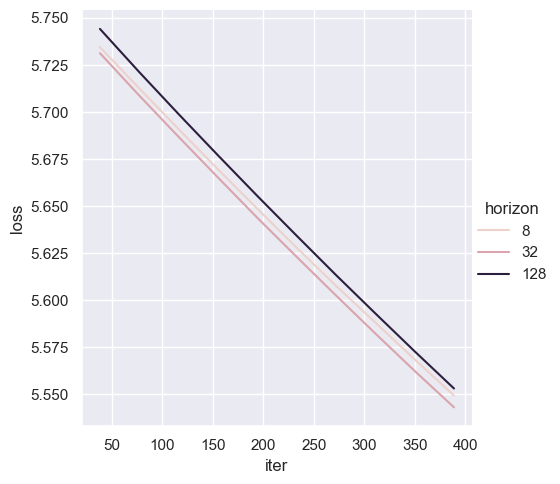

In [62]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert records_loss to a DataFrame for easy plotting
df_loss = pd.DataFrame(records_loss)

sns.set_theme(style="darkgrid")
sns.relplot(
    data=df_loss,
    x="iter",
    y="loss",
    kind="line",
    hue="horizon",
)

### Dataset complexity

Here we compare mnist with language

In [46]:
# Helper functions

import torch
import torchvision
from torchvision import transforms
import certifi
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

os.environ["SSL_CERT_FILE"] = certifi.where()


class ShakespeareDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        tokenizer,
        seq_len=256,
        max_samples=None,
        file_path="dataloaders/data/tinyshakespeare.txt",
    ):
        self.tokenizer = tokenizer
        self.seq_len = seq_len

        # Read Shakespeare text
        with open(file_path, "r", encoding="utf-8") as f:
            text = f.read()

        # Tokenize the entire text
        tokens = self.tokenizer.encode(text)

        # Limit samples if specified
        if max_samples:
            tokens = tokens[: max_samples * seq_len]

        # Create sequences
        self.sequences = []
        for i in range(0, len(tokens) - seq_len, seq_len // 2):  # 50% overlap
            seq = tokens[i : i + seq_len]
            if len(seq) == seq_len:
                self.sequences.append(seq)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        return {"input_ids": torch.tensor(seq, dtype=torch.long)}


class BPETokenizerWrapper:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        self.vocab_size = tokenizer.get_vocab_size()
        self.eos_token = "</s>"
        self.pad_token = "<pad>"
        self.eos_token_id = tokenizer.token_to_id(self.eos_token)
        self.pad_token_id = tokenizer.token_to_id(self.pad_token)

    def __len__(self):
        return self.vocab_size

    def encode(self, text, **kwargs):
        return self.tokenizer.encode(text).ids

    def decode(self, ids, skip_special_tokens=True):
        return self.tokenizer.decode(ids)

    def get_vocab_size(self):
        return self.vocab_size

def get_tokenizer(corpus_path, bit_size, n_bits_per_token):
    from tokenizers import Tokenizer
    from tokenizers import Tokenizer, models, trainers, pre_tokenizers, normalizers

    # Initialize
    tokenizer = Tokenizer(models.BPE())
    tokenizer.normalizer = normalizers.NFKC()
    tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

    # Setup trainer
    trainer = trainers.BpeTrainer(
        vocab_size=bit_size**n_bits_per_token,
        special_tokens=["<pad>", "<unk>", "<s>", "</s>"],
    )

    assert os.path.exists(corpus_path), f"File not found: {corpus_path}"

    # Train
    print("Vocab size before training:", tokenizer.get_vocab_size())
    tokenizer.train([corpus_path], trainer)

    # # Save and verify
    # tokenizer.save("bpe_tokenizer.json")
    print("Vocab size after training:", tokenizer.get_vocab_size())

    return BPETokenizerWrapper(tokenizer)


def get_mnist(n_samples: int = 1000, seq_len: int = 1000, data_dir: str = "./data", scale=None):
    """Create MNIST data loaders with binary thresholding."""
    transform = transforms.Compose([transforms.ToTensor(), lambda x: (x > 0.5).long()])
    if scale is not None:
        transform = transforms.Compose(
            [
                transforms.Resize(
                    (scale, scale)
                ),  # rescale from 28x28 -> (scale, scale)
                transforms.ToTensor(),
                lambda x: (x > 0.5).long(),  # binarize
            ]
        )
    # return torch.randint(0, 2, (n_samples, seq_len)).float()
    train_set = torchvision.datasets.MNIST(
        data_dir, train=True, transform=transform, download=True
    )
    # Give single tensor of shape (n_samples, seq_len)
    return torch.stack([t[0].reshape(-1) for t in train_set])[:n_samples, :seq_len].float()


def dec2bin(x, bits):
    # mask = 2 ** torch.arange(bits).to(x.device, x.dtype)
    dv, dt = x.device, x.dtype
    mask = 2 ** torch.arange(bits - 1, -1, -1).to(dv, dt)
    return x.unsqueeze(-1).bitwise_and(mask).ne(0).to(dt)

def get_shakespeare(
    n_samples: int = 1000, 
    seq_len: int = 1000, 
    dataset_path: str = "../data/shakespeare/main.txt", 
    bit_size: int = 2, 
    n_bits_per_token: int = 8
):
    # return torch.randint(0, 2, (n_samples, seq_len)).float()
    tokenizer = get_tokenizer(corpus_path=dataset_path, bit_size=bit_size, n_bits_per_token=n_bits_per_token)
    dataset = ShakespeareDataset(tokenizer, seq_len=seq_len, max_samples=n_samples, file_path=dataset_path)
    dataset = torch.stack([t["input_ids"] for t in dataset])[:n_samples]  # (n_samples, seq_len)
    dataset = dec2bin(dataset, n_bits_per_token)
    return dataset.reshape(n_samples, -1)[:, :seq_len].float()


def standardize(dataset: torch.Tensor):
    # Shape: (n_samples, seq_len)
    return (dataset - dataset.mean(dim=0))


# dataset_mnist = get_mnist()
# dataset_shakespeare = get_shakespeare()
# for name, dataset in {"mnist": dataset_mnist, "shakespeare": dataset_shakespeare}.items():
#     print(f"{name} dataset shape: {dataset.shape}")

datasets = {
    "mnist": get_mnist(),
    "shakespeare::2::4": get_shakespeare(bit_size=2, n_bits_per_token=4),
    "shakespeare::2::8": get_shakespeare(bit_size=2, n_bits_per_token=8),
    "shakespeare::2::16": get_shakespeare(bit_size=2, n_bits_per_token=16),
}


Vocab size before training: 0



Vocab size after training: 67
Vocab size before training: 0



Vocab size after training: 256
Vocab size before training: 0



Vocab size after training: 18150


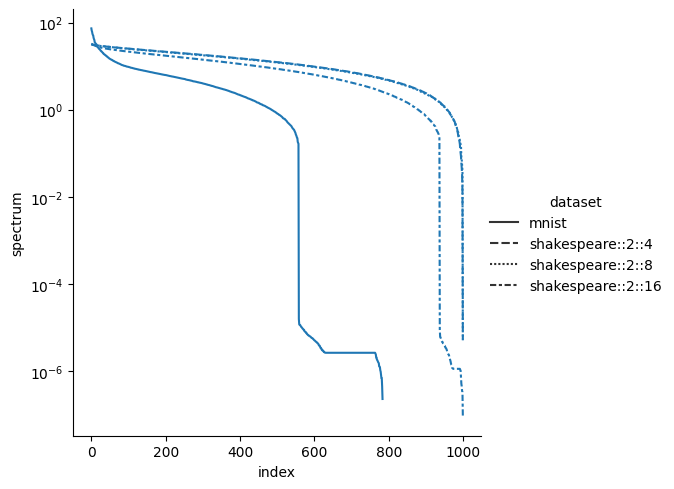

In [47]:
# Hyperparameters
n_samples = 10_000
seq_len = 1000

cols = []
for name, dataset in datasets.items():
    _, s, _ = torch.svd(standardize(dataset))
    cols.append({"dataset": name, "spectrum": s, "index": range(len(s))})

dfs = [pd.DataFrame(col) for col in cols]
df = pd.concat(dfs)

# Use seaborn but assign different markers per dataset using style=
sns.relplot(
    data=df,
    x="index",
    y="spectrum",
    kind="line",
    style="dataset",   # Add marker differentiation by dataset
)
plt.yscale("log")  # Apply log scale to y-axis (may log scale)
